# First attempt at a solution, problem statement below

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:
<div>
<img src="https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png", width="200"/>
</div>

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from spellchecker import SpellChecker
import spacy
import tqdm
from sklearn.model_selection import train_test_split

import nltk.corpus
#nltk.download('stopwords')
#from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize
nltk.download('punkt')


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.backend import clear_session
import keras.metrics as metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model



%matplotlib inline
pd.set_option('max.column', 100)
pd.set_option('max.row', 100)
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 15,8
pd.set_option('display.max_colwidth', None)
sns.set()
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## import data

In [104]:
df = pd.read_csv(r'../data/train.csv')
test = pd.read_csv(r'../data/test.csv')

df.shape, test.shape

((7613, 5), (3263, 4))

In [105]:
df.isnull().sum() / len(df)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

<AxesSubplot:>

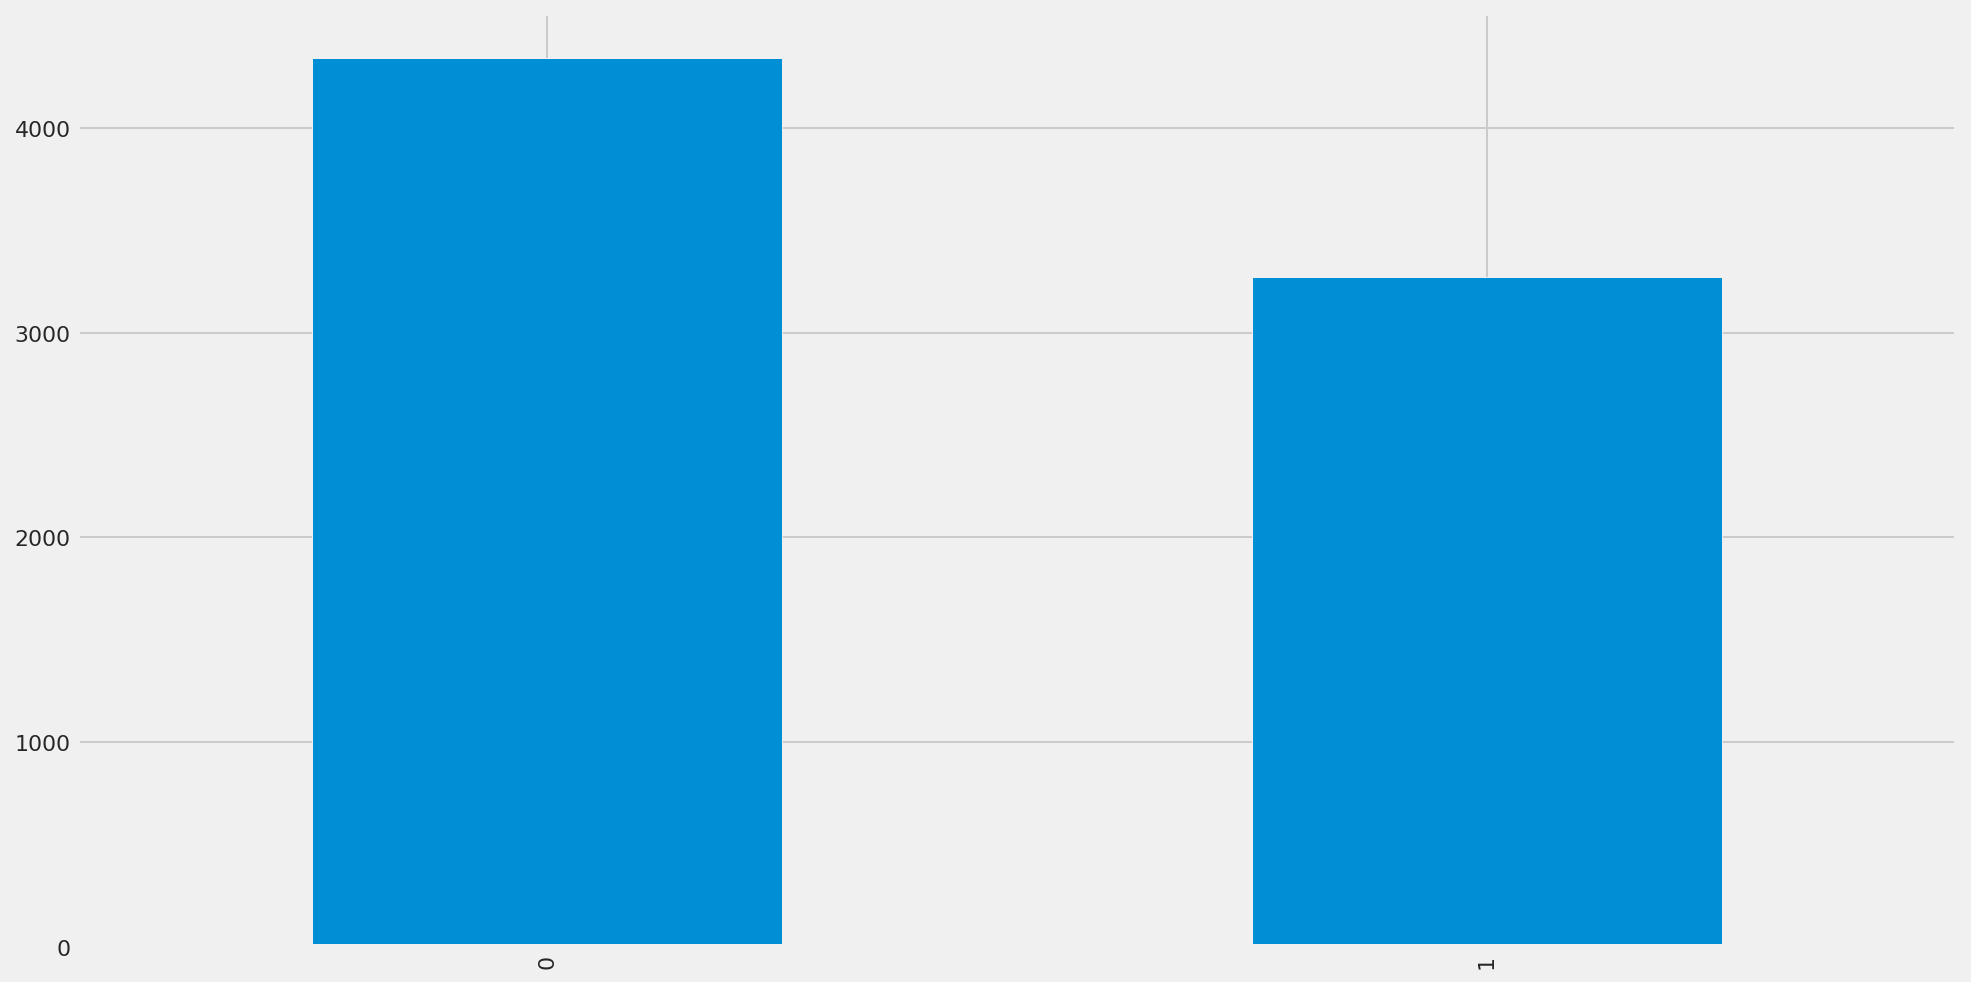

In [106]:
df['target'].value_counts().plot(kind='bar')

## Data Cleansing

In [107]:
# Remove URLs

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))

In [108]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [109]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_emoji(x))

In [110]:
## created a piece to spell correct, but it takes way too long to do


#%%time 
#
#spell = SpellChecker(tokenizer=True)
#
#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = spell.unknown(text.split())
#    for word in text.split():
#        if word in misspelled_words:
#            corrected_text.append(spell.correction(word))
#        else:
#            corrected_text.append(word)
#    return " ".join(corrected_text)
#
#
#df['text'][:50].apply(lambda x : correct_spellings(x))

## Create Corpus 

In [111]:
!spacy download en_core_web_sm

2021-10-06 11:44:17.923922: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-06 11:44:17.924014: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.6 MB 7.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [113]:
nlp = spacy.load("en_core_web_sm")

In [114]:
%%time
df['tokenized'] = df['text'].apply(nlp)

CPU times: user 1min 4s, sys: 60.7 ms, total: 1min 4s
Wall time: 1min 4s


In [115]:
# should split up, removes stop words, punctuation, useless words and lemmatizes

df['tokenized_clean'] = df['tokenized'].apply(lambda doc: ' '.join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct
                                                                   and not token.pos_=='X']))

In [116]:
%%time
df['sent_vectors'] = df['tokenized'].apply(lambda doc: np.mean([token.vector for token in doc]))

CPU times: user 434 ms, sys: 1.75 ms, total: 436 ms
Wall time: 434 ms


In [117]:
df['char_len'] = df['tokenized_clean'].apply(lambda x: len(x))
df['word_len'] = df['tokenized_clean'].apply(lambda x: len(x.split()))

In [164]:
corpus = []
for text in df['tokenized_clean']:
    words = [word.lower() for word in word_tokenize(text)] 
    corpus.append(words)

num_words = len(corpus)
print(num_words)

7613


In [165]:
X = df['tokenized_clean']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5329,) (5329,)
(2284,) (2284,)


In [166]:
df.shape

(7613, 10)

In [167]:
max_len = 32
tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=max_len, truncating='post', padding='post')

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len, truncating='post', padding='post')

print(f'Number of unique words: {len(tokenizer.word_index)}')

Number of unique words: 12226


In [25]:
# Source: https://zenodo.org/record/3237458#.YVws_UbMK3J
# Original Source: https://github.com/stanfordnlp/GloVe

embedding = {}
with open("../data/input/glove.twitter.27B.100d.txt") as file:
    for line in file:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding[word] = vectors
file.close()

print(f"Number of words in embedding file: {len(embedding)}")

Number of words in embedding file: 1193515


In [168]:
print(f"Number of words in embedding file: {len(embedding)}")

Number of words in embedding file: 1193515


In [169]:
embedding_matrix = np.zeros((num_words+1, 100))
for i, word in tokenizer.index_word.items():
    if i < (len(corpus)+1):
        vector = embedding.get(word)
        if vector is not None:
            embedding_matrix[i] = vector

In [170]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5329, 32) (5329,)
(2284, 32) (2284,)


## Modelling 

In [171]:
num_words

7613

In [172]:
embedding_matrix.shape

(7614, 100)

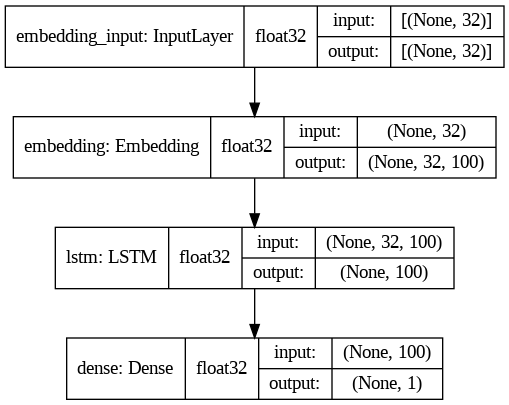

In [173]:
clear_session()
model = Sequential()

model.add(Embedding(input_dim=num_words+1, output_dim=100, 
                    embeddings_initializer=Constant(embedding_matrix), 
                    input_length=32, trainable=False))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, show_shapes=True, show_dtype=True)

In [174]:
history = model.fit(X_train, y_train, epochs=5, batch_size=256, 
                    validation_data=(X_test, y_test))

Epoch 1/5
21/21 [==============================] - 5s 127ms/step - loss: 0.6044 - accuracy: 0.6654 - val_loss: 0.4829 - val_accuracy: 0.7881
Epoch 2/5
21/21 [==============================] - 2s 108ms/step - loss: 0.4793 - accuracy: 0.7851 - val_loss: 0.4519 - val_accuracy: 0.8095
Epoch 3/5
21/21 [==============================] - 2s 107ms/step - loss: 0.4538 - accuracy: 0.7960 - val_loss: 0.4464 - val_accuracy: 0.8017
Epoch 4/5
21/21 [==============================] - 2s 109ms/step - loss: 0.4382 - accuracy: 0.8062 - val_loss: 0.4353 - val_accuracy: 0.8095
Epoch 5/5
21/21 [==============================] - 2s 115ms/step - loss: 0.4355 - accuracy: 0.8129 - val_loss: 0.4329 - val_accuracy: 0.8122


In [177]:
history.history

{'loss': [0.6044393181800842,
  0.4793252944946289,
  0.45380812883377075,
  0.4381994307041168,
  0.4354684352874756],
 'accuracy': [0.6654156446456909,
  0.785137951374054,
  0.7960217595100403,
  0.8061550259590149,
  0.8129104971885681],
 'val_loss': [0.48292726278305054,
  0.45190349221229553,
  0.44644850492477417,
  0.4353454113006592,
  0.4328729510307312],
 'val_accuracy': [0.7880910634994507,
  0.8095446825027466,
  0.8016637563705444,
  0.8095446825027466,
  0.8121716380119324]}

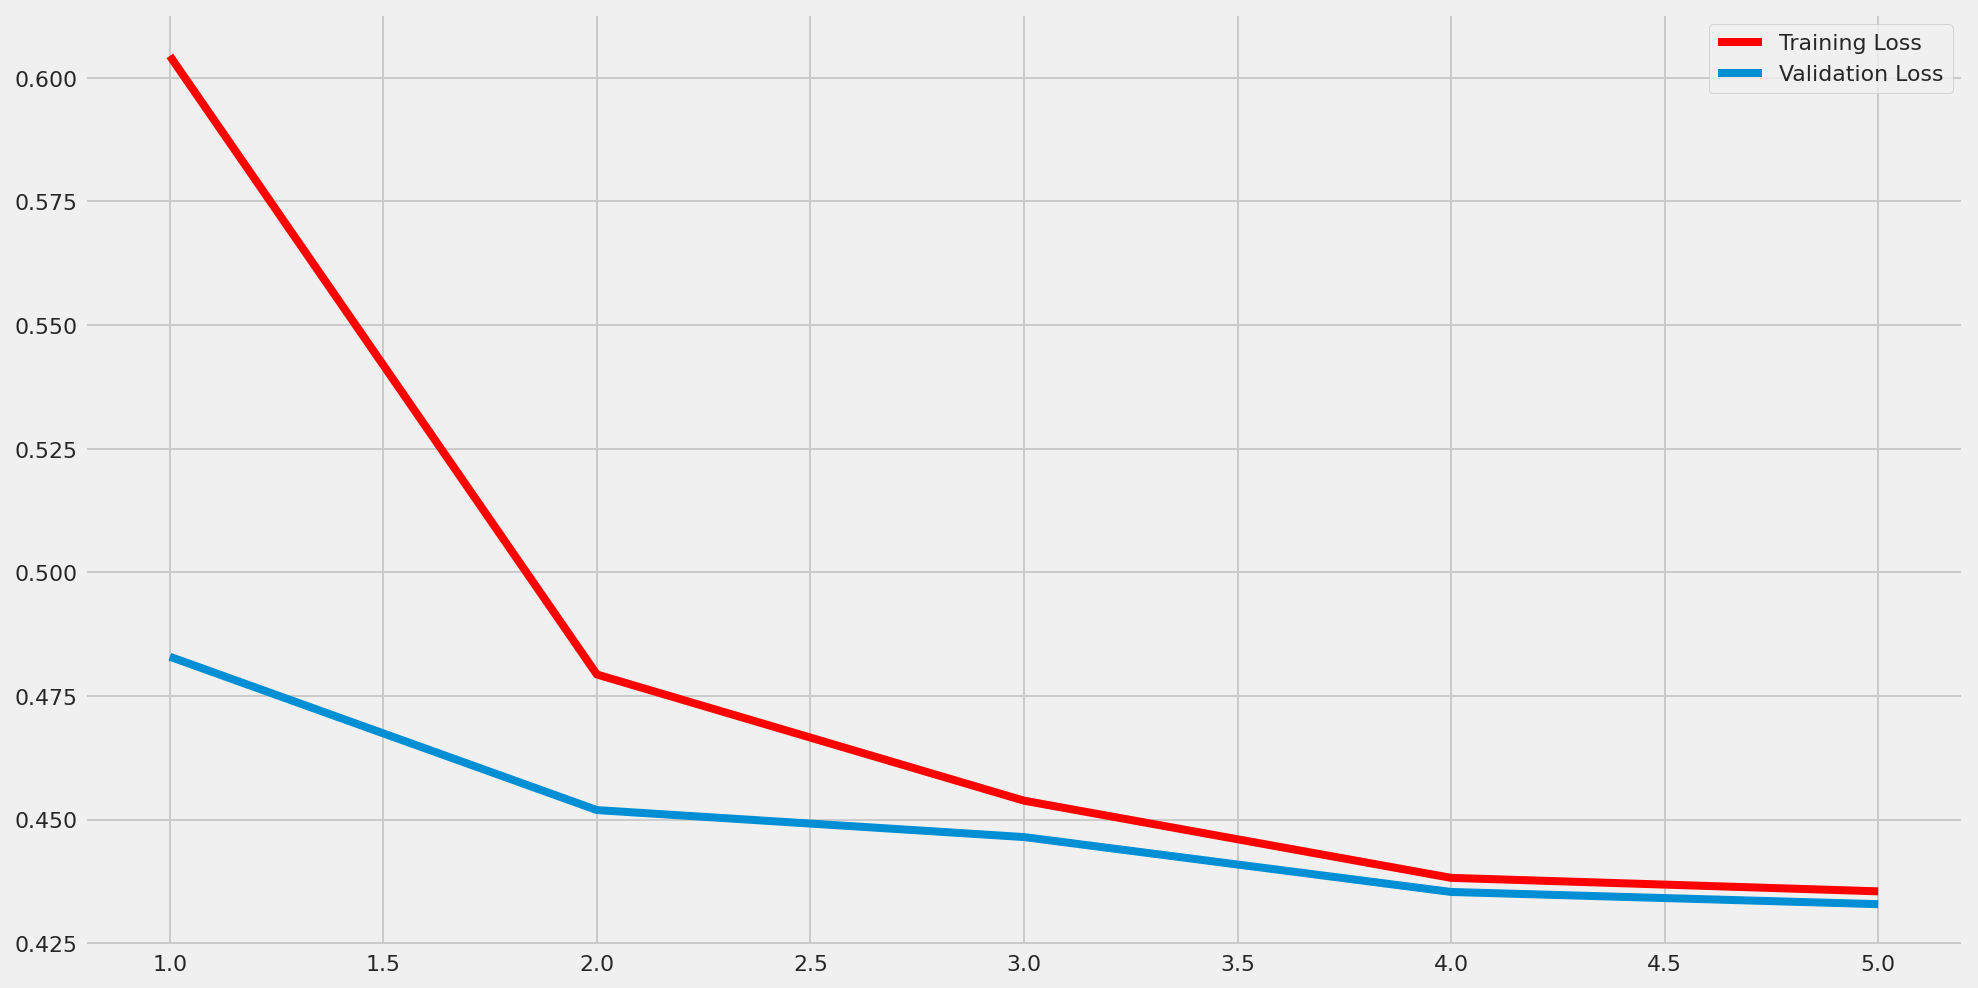

In [179]:
epochs = range(1, len(history.history['accuracy'])+1)
plt.plot(epochs, history.history['loss'], label='Training Loss', color='red')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

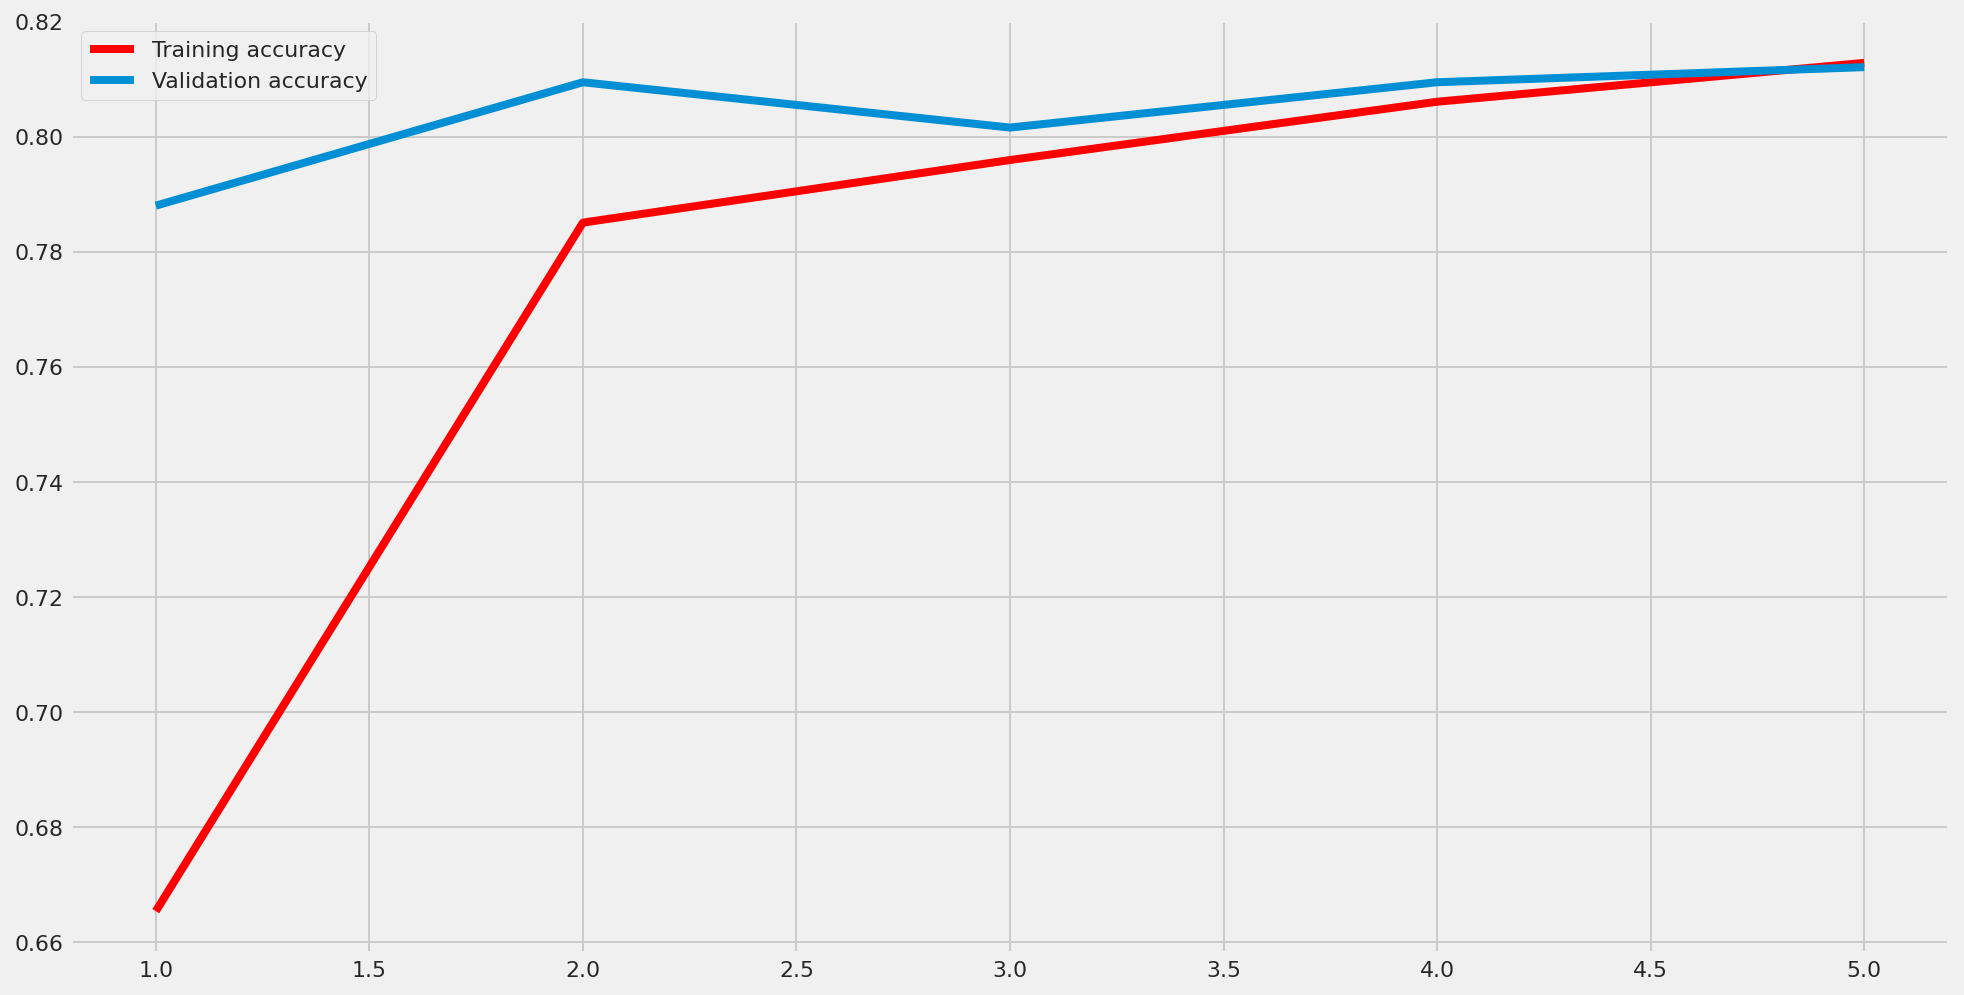

In [182]:
plt.plot(epochs, history.history['accuracy'], label='Training accuracy', color='red')
plt.plot(epochs, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

## Prediction time 

In [198]:
y_pred = np.round(model.predict(X_test)).astype(int)
y_pred_prob = model.predict(X_test)

In [199]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1318
           1       0.80      0.74      0.77       966

    accuracy                           0.81      2284
   macro avg       0.81      0.80      0.81      2284
weighted avg       0.81      0.81      0.81      2284



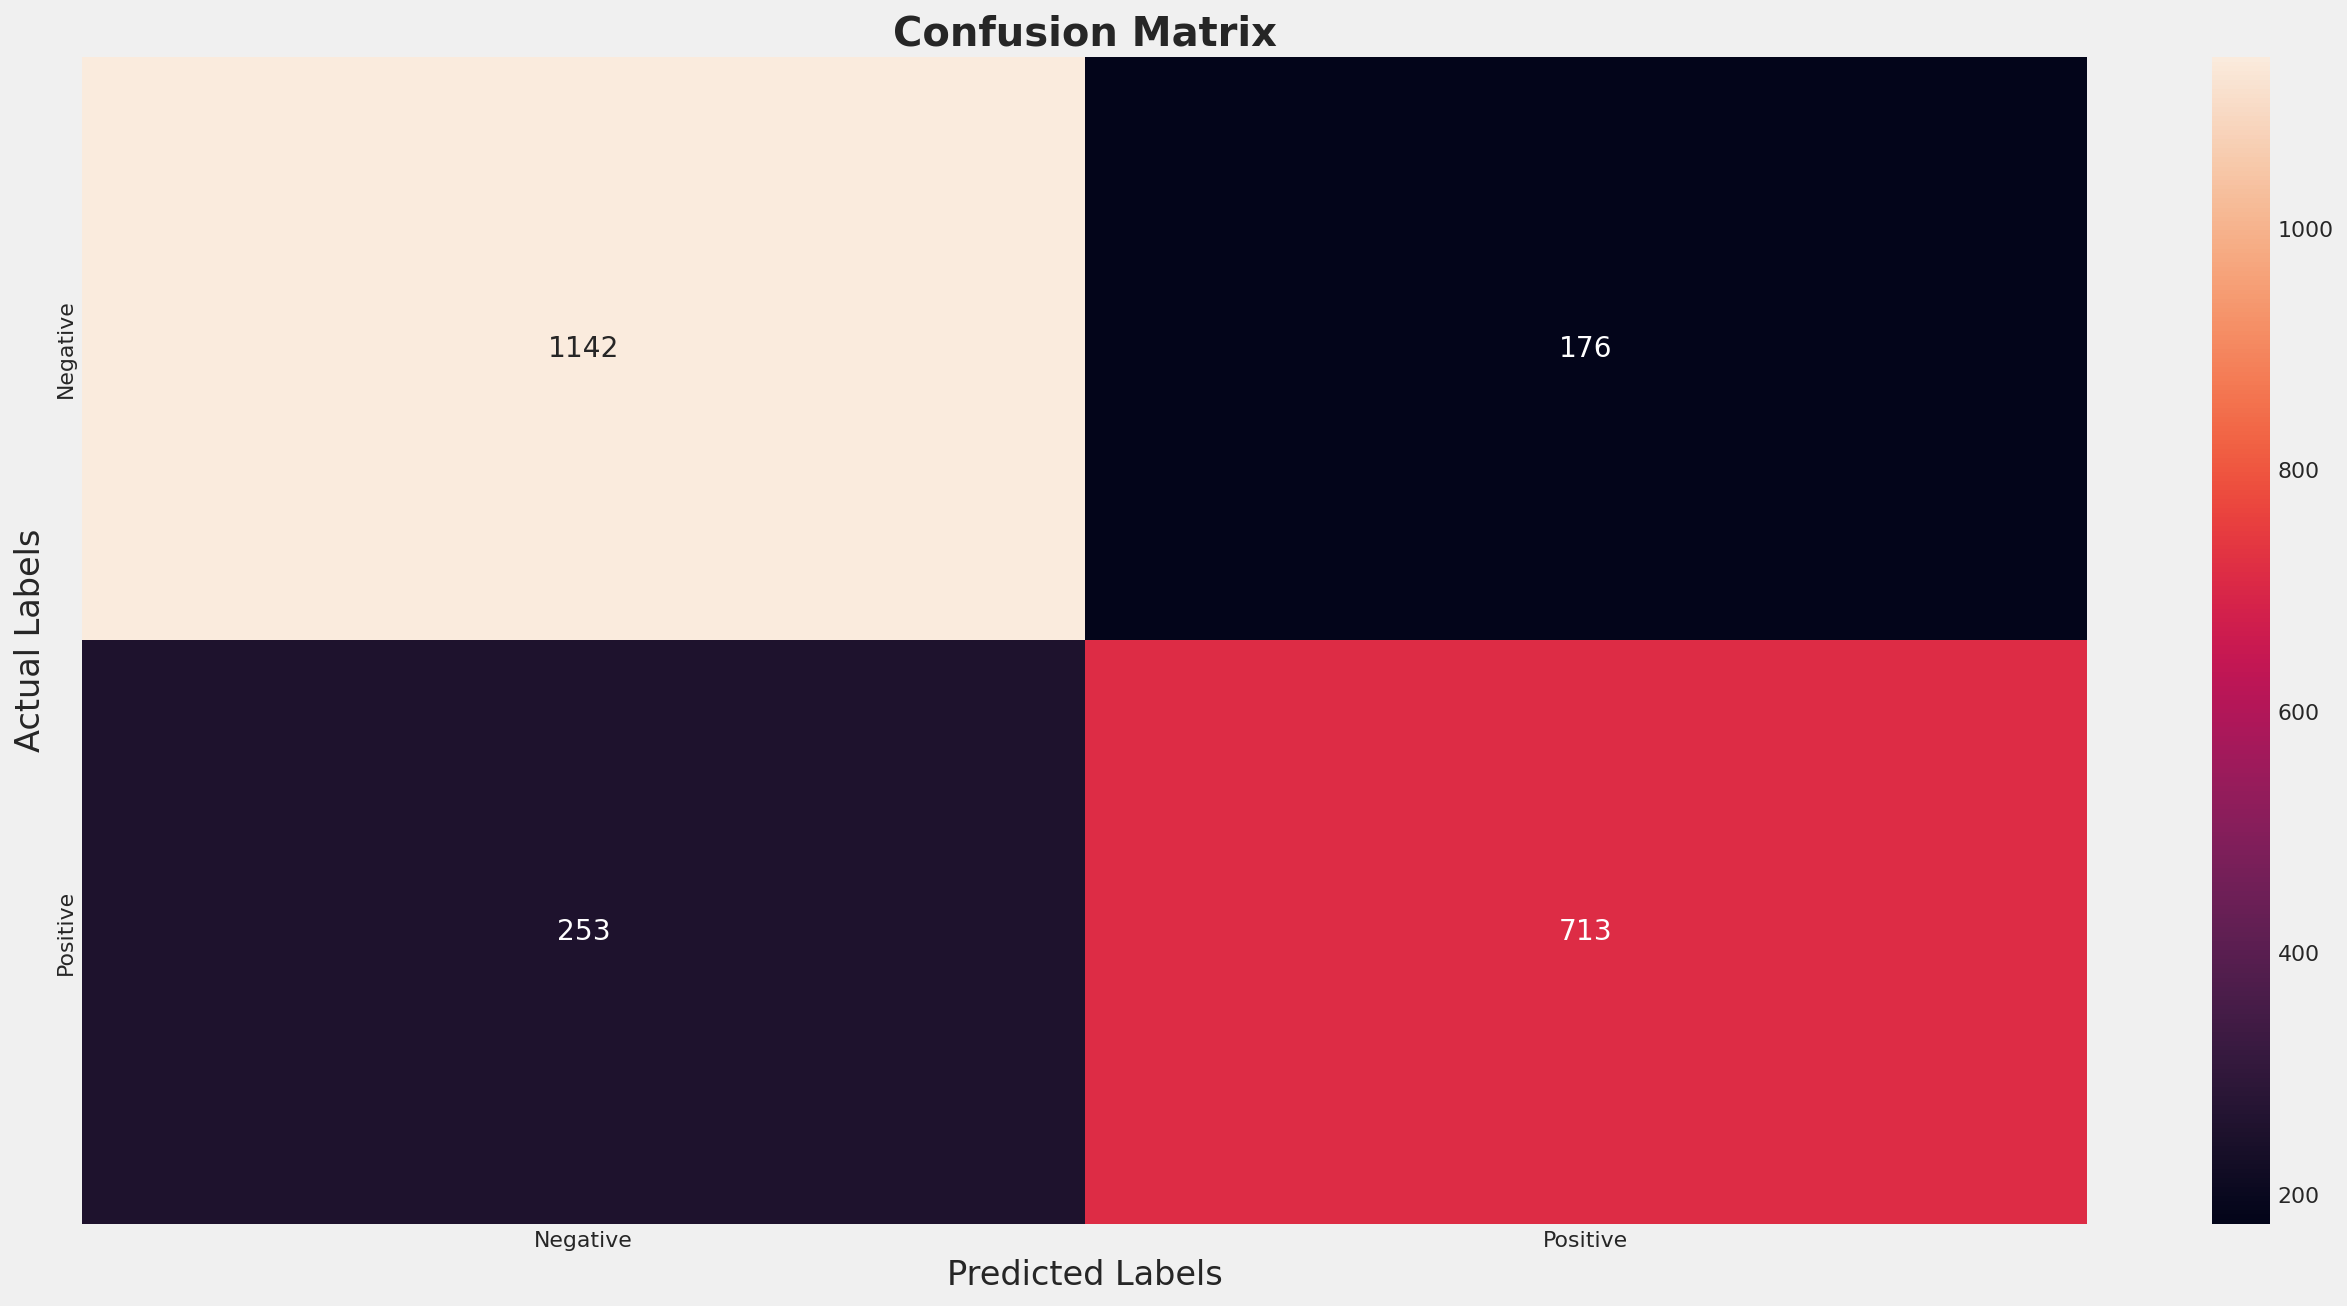

In [203]:
labels= ["Negative", "Positive"]
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix", size=20, weight="bold")
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.xticks(ticks=[0.5, 1.5], labels=labels)
plt.show()